In [1]:
from pathlib import Path

import matplotlib.pyplot as plt

import h5py
import numpy as np
from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

from mpl_toolkits.axes_grid1 import make_axes_locatable

def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [2]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "20_200_36_9.h5", "r")

except FileNotFoundError:
    db_kwargs = {
        "res": [36, 9, 1],
        "grid_size": [500e-9, 125e-9, 3e-9],
        "n_seq": 20,
        "t_steps": 200,
        "t_per_step": 10e-12,
        "cuda": True,
    }

    create_db_mp("std_prob_4", n_workers=1, **db_kwargs)

In [3]:
print("Attributes of database:")
for key in db.attrs:
    print(f"{key}: {db.attrs[key]}")

print("\nData in the database:")
for key in db:
    print(f"{key}: {db[key].shape}")

Attributes of database:
grid_size: [5.00e-07 1.25e-07 3.00e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [36  9  1]
seed: 0
t_per_step: 1e-11
t_steps: 200

Data in the database:
field: (20, 3)
sequence: (20, 200, 36, 9, 3)


In [4]:
Hs = np.array(db["field"])

data = np.array(db["sequence"])

n_seq, n_tsteps, data_dim = *data.shape[:2], data.shape[2:]

data = data.reshape((n_seq, n_tsteps, -1))
Xs = data[:, :-1, :]
Ys = data[:,  1:, :]

print(f"Concatenated dimension: from {data_dim} to ({np.prod(data_dim)},)")

print(f"Xs shape: {Xs.shape} (n_seq, n_tsteps - 1, n_x * n_y * 3)")
print(f"Ys shape: {Xs.shape} (n_seq, n_tsteps - 1, n_x * n_y * 3)")

db.close()

Concatenated dimension: from (36, 9, 3) to (972,)
Xs shape: (20, 199, 972) (n_seq, n_tsteps - 1, n_x * n_y * 3)
Ys shape: (20, 199, 972) (n_seq, n_tsteps - 1, n_x * n_y * 3)


In [5]:
Xtorch = torch.tensor(Xs, dtype=torch.float32)
Ytorch = torch.tensor(Ys, dtype=torch.float32)

Htorch = torch.stack(
    [
        torch.stack(
            [torch.tensor(Hs[i], dtype=torch.float32) for _ in range(n_tsteps - 1)]
        )
        for i in range(n_seq)
    ]
)

print(f"H shape: {Htorch.shape} (n_seq, n_tsteps - 1, n_x * n_y * 3)")

H shape: torch.Size([20, 199, 3]) (n_seq, n_tsteps - 1, n_x * n_y * 3)


### Koopman Autoencoder

In [9]:
class FCEncoder(nn.Module):
    '''
    Encoder block for Autoencoder with fully connected layers.
    takes as input a list of number of nodes per layer
    and an activation function
    '''
    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super().__init__()

        module_list = []
        for i in range(len(dim_list)-1):
            module_list.append(nn.Linear(dim_list[i], dim_list[i+1]))
            if i != len(dim_list)-2:
                module_list.append(act_fn())

        self.fc = nn.Sequential(*module_list)

    def forward(self, x) -> torch.Tensor:
        return self.fc(x)


class FCDecoder(nn.Module):
    '''
    Decoder block for Autoencoder with fully connected layers.
    takes as input a list of number of nodes per layer
    and an activation function
    '''
    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super().__init__()
        module_list = []
        for i in range(len(dim_list)-1, 0, -1):
            module_list.append(nn.Linear(dim_list[i], dim_list[i-1]))
            if i != 1:
                module_list.append(act_fn())

        self.fc = nn.Sequential(*module_list)

    def forward(self, x) -> torch.Tensor:
        return self.fc(x)
    
    
class DeepKoopman(nn.Module):

    def __init__(self, dim_list, act_fn=nn.Tanh) -> None:
        super().__init__()
        self.encoder = FCEncoder(dim_list, act_fn)
        self.decoder = FCDecoder(dim_list, act_fn)

        self.B = nn.Parameter(torch.empty(3, dim_list[-1])) # shape (n_magnetization, d)
        nn.init.xavier_uniform_(self.B, gain=0.01)          # initialise B matrix values


    def compute_linear_operator_pinv(self, Xtilde, Ytilde) -> torch.Tensor:

        self.A = torch.linalg.pinv(Xtilde, rcond=1e-4) @ Ytilde
        return self.A
    
    def compute_linear_operator_tikh(self, Xtilde, Ytilde, lam=1e-1):
    # Xtilde: (n, d), Ytilde: (n, d)
        XtX = Xtilde.T @ Xtilde             # (d, d)
        d   = XtX.shape[0]
        reg = lam * torch.eye(d, device=XtX.device)
        self.A   = torch.linalg.solve(XtX + reg, Xtilde.T @ Ytilde)
        #while torch.any(torch.isnan(self.A)):
        #    lam *= 2
        #    reg = lam * torch.eye(d, device=XtX.device)
        #    self.A   = torch.linalg.solve(XtX + reg, Xtilde.T @ Ytilde)
        return self.A

    def forward(self, X, Y, U=None) -> tuple[torch.Tensor, torch.Tensor]:
        '''
        params:
        X: input data (n x m)
        Y: target data (n x m)
        U: external effect (n x 3)
        '''
        T = X.shape[0]
        T_half = T // 2
        Xtilde = self.encoder(X)    # encode X: (n x m)  -> Xtilde: (n x d)
        Ytilde = self.encoder(Y)    # encode Y: (n x m)  -> Ytilde: (n x d)

        ext_effect = U[:T_half, :] @ self.B if U is not None else 0 # shape (n//2 x d)

        # compute linear operator according to 
        # A = (Ytilde - B @ U) @ Xtilde^+
        A = self.compute_linear_operator_tikh(
            Xtilde[:T_half,:], Ytilde[:T_half,:] - ext_effect
            )

        Ytilde_pred_list = [Xtilde[0] @ A]
        for t in range(1, T):
            next_pred = Ytilde_pred_list[t-1] @ A
            if U is not None:
                next_pred += U[t,:] @ self.B
            Ytilde_pred_list.append(next_pred)
        
        Ytilde_pred = torch.stack(Ytilde_pred_list, dim=0)
        
        Xhat = self.decoder(Xtilde)
        Yhat = self.decoder(Ytilde_pred)

        return Xhat, Yhat
    
    
    def predict(self, X, T, U=None) -> torch.Tensor:
        if len(X.shape) == 1:
            X = X.unsqueeze(0)  # make it (1, input_dim)

        with torch.no_grad():
            Xtilde0 = self.encoder(X)    # encode X: (n x m)  -> Xtilde: (n x d)
            Ytilde_pred = torch.zeros((T, Xtilde0.shape[1])).to(Xtilde0.device)
            Ytilde_pred[0] = Xtilde0 @ self.A 
            if U is not None:
                Ytilde_pred[0] += U[0,:] @ self.B
            for t in range(1, T):
                Ytilde_pred[t] = Ytilde_pred[t-1] @ self.A
                if U is not None:
                    Ytilde_pred[t] += U[t,:] @ self.B
            
            Yhat = self.decoder(Ytilde_pred)
        return Yhat

In [10]:
m = int(np.prod(data_dim))  # input dimension
dim_list = [m, 265, 128, 8]      # hidden dimension in autoencoder
act_fn = nn.Tanh            # activation function in autoencoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DeepKoopman(dim_list, act_fn).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [8]:
id = 1
XX = Xtorch[id].to(device)
YY = Ytorch[id].to(device)
UU = Htorch[id].to(device)
model.train()
optimizer.zero_grad()
Xout, Yout = model(XX, YY, UU)
loss = criterion(Xout, YY) + criterion(Yout, YY)
loss.backward()
optimizer.step()
print(f"Loss: {loss.item()}")
print(model.A)

Loss: 0.706167995929718
tensor([[ 0.0997,  0.2030, -0.1687,  0.0937],
        [ 0.2142,  0.4633, -0.3945,  0.2252],
        [-0.1997, -0.4407,  0.3788, -0.2178],
        [ 0.0910,  0.2074, -0.1803,  0.1050]], device='cuda:0',
       grad_fn=<LinalgSolveExBackward0>)


In [11]:
epochs = 100
print_every = 1

losses = np.zeros(epochs)

for epoch in range(epochs):

    running_loss = 0.0
    for batch in range(n_seq):
        for _ in range(10):
            Xtrain = Xtorch[batch].to(device)
            Ytrain = Ytorch[batch].to(device)
            U = Htorch[batch].to(device)

            model.train()
            optimizer.zero_grad()

            Xhat, Yhat = model(Xtrain, Ytrain, U=U)

            loss = criterion(Xhat, Xtrain) + criterion(Yhat, Ytrain)

            loss.backward()
            optimizer.step()
            
        running_loss += loss.item()
    
    losses[epoch] = running_loss / n_seq

    if epoch % print_every == print_every - 1:
        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: nan


KeyboardInterrupt: 

In [24]:
errors = np.zeros((n_seq, n_tsteps - 1))

model.eval()

for i in range(n_seq):
    Xinit = Xtorch[i, 0].to(device)
    U = Htorch[i].to(device)

    Yhat = model.predict(Xinit, n_tsteps - 1, U=U).cpu().detach().numpy()

    Ytrain = Ytorch[i].detach().cpu().numpy()

    errors[i] = np.linalg.norm(Yhat - Ytrain, axis=1) / np.linalg.norm(Ytrain, axis=1)

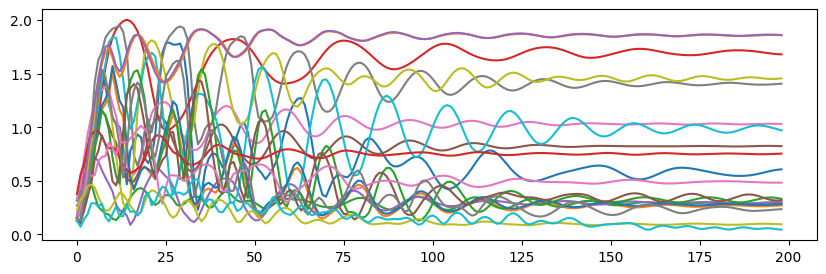

In [25]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(errors.T)
#ax.scatter(np.arange(len(error)), error, s=5, c="r")
plt.show()